In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
%cd "/gdrive/My Drive/Colab Notebooks/plate-detector"

/gdrive/My Drive/Colab Notebooks/plate-detector


In [3]:
# Importation des bibliothéques utiles
import os
import sys
import random # Pour la génération aléatoire
import shutil # Pour la suppression des chemins 
import itertools
import numpy as np # Pour les calculs matriciels
import matplotlib.pyplot as plt # Pour la visualisation en Jupyter
from PIL import Image, ImageDraw, ImageFont # Pour son support de la langue arabe
import cv2 # Indispensable pour le traitement d'images :)

%matplotlib inline

In [8]:
## Variables du scripts :

FONT_HEIGHT = 30  # Le nombre de pixels dans un caractère´: Contrôle la qualité
MAX_RUNS = 10000 # Nombre d'images à générer
PLATE_H_INTERVAL = (110,180) # Intervale de la largeur d'une plaque
PLATE_W_INTERVAL = (500,700) # Intervale de la longueur d'une plaque
OUTPUT_SHAPE = (240, 320) # Dimension de l'image de sortie
DEFAULT_POSITION = 0 # Une constante définissant l'absence de plaque dans l'image
NOISE_SCALE = 0.05 # Le rapport de bruit(par rapport à 1) : Pratiquement entre 0.01 et 0.1
ROOT_DIR = '/gdrive/My Drive/Colab Notebooks/plate-detector/'
FONT_DIR = ROOT_DIR + 'fonts/'
BGS_DIR = ROOT_DIR + 'bgs/'
DATA_DIR = ROOT_DIR + 'data/GENERATED_DATASET/'
IMGS_DIR = DATA_DIR + 'imgs/'
ANNS_DIR = DATA_DIR + 'anns/'
DIRS = [IMGS_DIR, ANNS_DIR]

# Les fontes des lettres et nombres utilisées pour les plaques marocaines
numbers_fonts = {'font_1' : ImageFont.truetype(FONT_DIR + 'numbers/' + '1.ttf', FONT_HEIGHT * 4), 
                 'font_2' : ImageFont.truetype(FONT_DIR + 'numbers/' + '2.ttf', FONT_HEIGHT * 4)} 
letters_fonts = {'font_1' : ImageFont.truetype(FONT_DIR + 'letters/' + '1.ttf', FONT_HEIGHT * 4),
                 'font_2' : ImageFont.truetype(FONT_DIR + 'letters/' + '2.ttf', FONT_HEIGHT * 4)}

letters = ['أ', 'ب', 'ج', 'د', 'ش', 'س']
numbers = ['1','2','3','4','5','6','7','8','9','0']
# L'utilisation des lettres latins est justifiée par l'incompatibilité du systéme d'exploitation
latin_letters = {'أ':'A', 'ب':'B', 'ج':'J', 'د':'D', 'ش':'X', 'س':'S', }

In [5]:
## Une fonction pour les simples détections

def bounding_box(mask, default = DEFAULT_POSITION, output = OUTPUT_SHAPE):
    '''Une fonction qui retourne les coordonnées du rectangle limitant l'objet blanc (pixel = 1)
       dans une image noire (pixel = 0)'''
    
    top = default
    bottom = default
    for i in range(0,output[0],1):
        if top == default and any(mask[i] > 0) :
            top = i
        if bottom == default and any(mask[output[0] - 1 - i] > 0) :
            bottom = output[0] - 1 - i
        if top != default and bottom != default :
            break
    left = default
    right = default
    for i in range(0,output[1],1):
        if left == default and any(mask.T[i] > 0) :
            left = i
        if right == default and any(mask.T[output[1] - 1 - i] > 0) :
            right = output[1] - 1 - i
        if left != default and right != default :
            break
    return top, left, bottom, right

In [6]:
## Creation des nombres et lettres a utiliser lors de la creation de la plaque

letters_dim = {}
letters_img = {}
for font in letters_fonts :
    for letter in letters:
        tab = np.zeros((300, 300)) # Un tableau de dimensions suffisament grande pour qu'on écrit la lettre 
        img = Image.fromarray(tab) # Transformation en une image (Objet PIL.Image)
        draw = ImageDraw.Draw(img) # Un curseur permettant la modification (écriture) de l'image
        draw.text((60, 60), letter, font=letters_fonts[font]) # Ecriture la lettre au centre de l'image
        img = np.array(img) # Transformation en un tableau (Objet np.array)
        top, left, bottom, right = bounding_box(img, 0,(300, 300)) # Détection des contour de la lettre 
        img = img[top:bottom,left:right] # Extraction de la lettre
        letters_dim[font + '_' + letter] = (bottom - top, right - left) # Stockage des dimensions de la lettre
        letters_img[font + '_' + letter] = img # Stockage de la lettre
        
numbers_dim = {}
numbers_img = {}
for font in numbers_fonts :
    for number in numbers:
        tab = np.zeros((300, 300)) # it's known
        img = Image.fromarray(tab)
        draw = ImageDraw.Draw(img)
        draw.text((60,60), number, font=numbers_fonts[font])
        img = np.array(img)
        top, left, bottom, right = bounding_box(img, 0, (300, 300))
        img = img[top-5:bottom+5,left-5:right+5]
        numbers_dim[font + '_' + number] = (bottom - top + 10, right - left + 10)
        numbers_img[font + '_' + number] = img


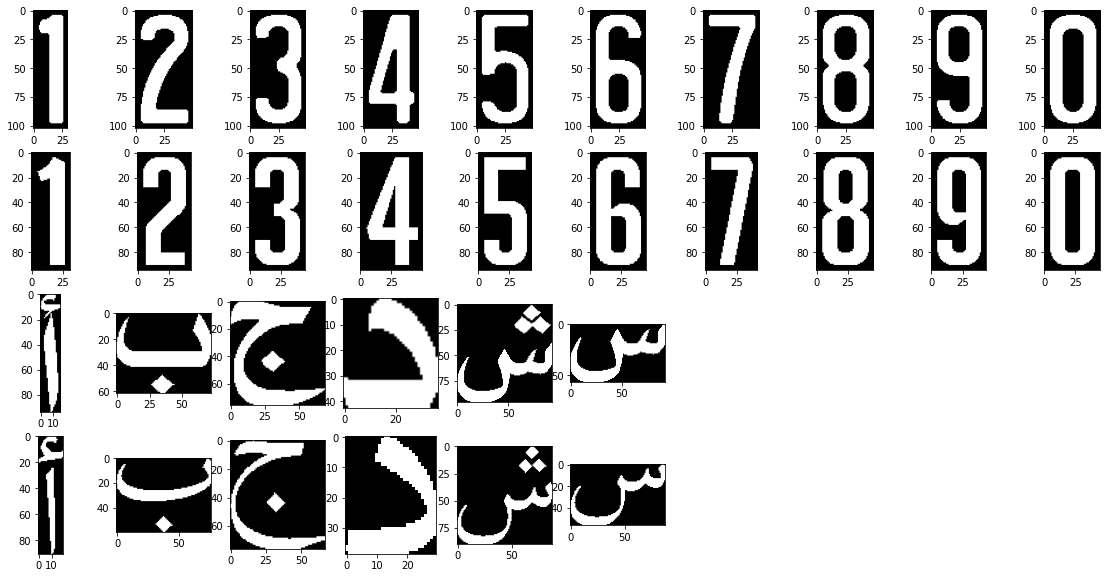

In [ ]:
# Visualisation des caractères créées

fig = plt.figure(figsize=(20, 10)) # Pour une multi-visualisation
columns = max(len(numbers), len(letters))
rows = len(numbers_fonts) + len(letters_fonts)

i = 1  # Un ompteur

for font in numbers_fonts:
    for number in numbers :
        img = numbers_img[font + '_' + number]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img,cmap='gray')
        i += 1

for font in letters_fonts:
    for letter in letters :
        img = letters_img[font + '_' + letter]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img,cmap='gray')
        i += 1
    i += columns - len(letters)

plt.show()

In [9]:
##Fonctions du programme :
def random_plate():
    ''' Une fonction permettant la creation d'une plaqueavec un numéro de matricule aléatoire
        Remarque : Les caractères 'flottent' sur la surface de la plaque.'''
    
    # Fixation des valeurs aléatoires
    plate_w = random.randint(*PLATE_W_INTERVAL)
    plate_h = random.randint(*PLATE_H_INTERVAL)
    number = str(random.randint(1, 99999))
    letter = random.sample(letters, 1)[0]
    region = str(random.randint(1, 99))
    line_width = np.random.randint(4,9)
    line_length = np.random.randint(plate_h - 40, plate_h - 20)
    number_font = random.sample(list(numbers_fonts),1)[0]
    letter_font = random.sample(list(letters_fonts),1)[0]
    
    # code = '{:<5}-{:}-{:<2}'.format(number, letter, region)
    latin_code = '{:<5}-{:}-{:<2}'.format(number, latin_letters[letter], region)
    plate = np.zeros((plate_h,plate_w))
    
    # l'ajout des motifs consecutivement suit une loi decroissante 
    # qui tend a positionner les nombres caractérisant la région extremmement à gauche.
    # Ma solution est de suivre un mouvement oscillatoir d'insertion
    
    # Ajout des nombres a gauche
    max_numbers_h = max([numbers_dim[number_font + '_' + n][0] for n in numbers])
    max_numbers_w = max([numbers_dim[number_font + '_' + n][1] for n in numbers])
    
    occupied = plate_w - len(number + region) * max_numbers_w - letters_dim[letter_font + '_' + letter][1] - 2 * line_width
    x_cursor = np.random.randint(0, occupied - 1)
    for n in number :
        y_cursor = np.random.randint(1, plate_h - numbers_dim[number_font + '_' + n][0])
        plate[y_cursor : y_cursor + numbers_dim[number_font + '_' + n][0], x_cursor : x_cursor + numbers_dim[number_font + '_' + n][1]] = numbers_img[number_font + '_' + n]
        x_cursor += numbers_dim[number_font +  '_' + n][1]
    
    # Ajout des nombres a droites (La region)
    occupied = x_cursor + line_width * 2 + letters_dim[letter_font + '_' + letter][1] + len(region) * max_numbers_w
    x2_cursor = np.random.randint(occupied - 1 , plate_w - 1)
    for n in region :
        x2_cursor -= numbers_dim[number_font +  '_' + n][1]
        y_cursor = np.random.randint(0, plate_h - numbers_dim[number_font + '_' + n][0])
        plate[y_cursor : y_cursor + numbers_dim[number_font + '_' + n][0], x2_cursor : x2_cursor + numbers_dim[number_font + '_' + n][1]] = numbers_img[number_font + '_' + n]
    
    # J'ai choisi une loi de Bernoulli pour caractériser l'exitence des lignes 
    if random.random() > 0.3 :
        # Ajout de La ligne a droite
        occupied = x2_cursor - letters_dim[letter_font + '_' + letter][1] - 2 * line_width
        x_cursor = np.random.randint(x_cursor - 1, occupied + 1)
        y_cursor = np.random.randint(1, plate_h - line_length)
        plate[y_cursor : y_cursor + line_length, x_cursor : x_cursor + line_width] = np.ones((line_length, line_width))
        x_cursor += line_width

        # Ajout de la ligne a gauche
        occupied = x_cursor + letters_dim[letter_font + '_' + letter][1] + line_width
        x2_cursor = np.random.randint(occupied - 1, x2_cursor + 1)
        x2_cursor -= line_width
        y_cursor = np.random.randint(0, plate_h - line_length)
        plate[y_cursor : y_cursor + line_length, x2_cursor : x2_cursor + line_width] = np.ones((line_length, line_width))
    
    # Ajout de la lettre
    occupied = x2_cursor - letters_dim[letter_font + '_' + letter][1]
    x_cursor = np.random.randint(x_cursor - 1, occupied + 1)
    y_cursor = np.random.randint(0, plate_h - letters_dim[letter_font + '_' + letter][0])
    plate[y_cursor : y_cursor + letters_dim[letter_font + '_' + letter][0], x_cursor : x_cursor + letters_dim[letter_font + '_' + letter][1]] = letters_img[letter_font + '_' + letter]
    return plate, latin_code

def pick_colors():
    '''Choix de couleurs utilisées pour la plaque et pour son contenu (les chiffres)
       Remarque : Le choix se fait avec la condition de visibilité des chiffres dans la plaque'''
    first = True
    
    # La couleur des caractères doit les permettre d'être visibles
    while first or plate_color - text_color < 0.5:
        text_color = random.random()
        plate_color = random.random()
        if text_color > plate_color:
            text_color, plate_color = plate_color, text_color
        first = False
    return text_color, plate_color

def matrice_rotation(yaw, pitch, roll):
    '''Une fonction permettant de générer une matrice de rotation tridimentionnelle
       à partir des trois angles fournies (yaw, pitch, roll)'''
    
    # Le produit des isométries (Rotations dans R3) est une isométrie (Rotation dans R3)
    
    # Rotation selon l'axe Y
    c, s = np.cos(yaw), np.sin(yaw)
    M = np.matrix([   [  c, 0.,  s],
                      [ 0., 1., 0.],
                      [ -s, 0.,  c]])
    
    # Rotation selon l'axe X
    c, s = np.cos(pitch), np.sin(pitch)
    M = np.matrix([   [ 1., 0., 0.],
                      [ 0.,  c, -s],
                      [ 0.,  s,  c]]) * M
    
    # Rotation selon l'axe Z
    c, s = np.cos(roll), np.sin(roll)
    M = np.matrix([   [  c, -s, 0.],
                      [  s,  c, 0.],
                      [ 0., 0., 1.]]) * M
    return M

def rounded_rect(shape, rayon):
    '''Un mask pour la plaque plus realiste (Les contours sont plutot des arcs / quarts de circle)'''
    out = np.ones(shape)
    
    # On ne laisse que les coins du mask (des petits carreax de cotes R avec R le rayon fourni en parametre)
    out[:rayon, :rayon] = 0.0
    out[-rayon:, :rayon] = 0.0
    out[:rayon, -rayon:] = 0.0
    out[-rayon:, -rayon:] = 0.0
    
    # On remplit les cercle de rayon R sur les quatres qoins du mask
    cv2.circle(out, (rayon, rayon), rayon, 1.0, -1)
    cv2.circle(out, (rayon, shape[0] - rayon), rayon, 1.0, -1)
    cv2.circle(out, (shape[1] - rayon, rayon), rayon, 1.0, -1)
    cv2.circle(out, (shape[1] - rayon, shape[0] - rayon), rayon, 1.0, -1)
    return out

def generate_plate(font_height):
    '''Une fonction combinant les éléments de la plaque'''
    
    rayon = 1 + int(font_height * 0.5 * random.random())
    text_color, plate_color = pick_colors()
    text_mask, latin_code = random_plate()
    out_shape = text_mask.shape
    plate = (np.ones(out_shape) * plate_color * (1. - text_mask) + np.ones(out_shape) * text_color * text_mask)
    mask = rounded_rect(out_shape, rayon)
    return plate, mask, latin_code

def generate_bg(num_bg_images):
    ''' Une fonction qui retourne une image négative dimensionnée par les dimensions de la sortie '''
    
    found = False
    while not found:
        # Prendre une image négative aléatoire
        fname = BGS_DIR + '{:08d}.jpg'.format(random.randint(0, num_bg_images - 1))
        bg = cv2.imread(fname)
        bg = cv2.cvtColor(bg, cv2.COLOR_RGB2GRAY) / 255
        
        # Puisque les images sont de dimensions variables, on s'assure que l'image peut founir la résolution demandé
        if (bg.shape[1] >= OUTPUT_SHAPE[1] and bg.shape[0] >= OUTPUT_SHAPE[0]):
            found = True
    
    # Rogner les images négatives : ce processus permet de créer plus d'arrières plans
    x = random.randint(0, bg.shape[1] - OUTPUT_SHAPE[1])
    y = random.randint(0, bg.shape[0] - OUTPUT_SHAPE[0])
    bg = bg[y:y + OUTPUT_SHAPE[0], x:x + OUTPUT_SHAPE[1]]
    return bg

def make_affine_transform(from_shape, to_shape, 
                          min_scale, max_scale,
                          scale_variation=1.0,
                          rotation_variation=1.0,
                          translation_variation=1.0):
    ''' Une fonction qui retourne une matrice de transformation affine 
        et une valeur booléenne caractérisant la sortie de la plaque des limites de l'image 
        à partir des paramètres et limites de rotation, translation et dimensionnement '''
    
    from_size = np.array([[from_shape[1], from_shape[0]]]).T # Vecteur colonne de dimensions de la plaque
    to_size = np.array([[to_shape[1], to_shape[0]]]).T # Vecteur colonne de dimensions de l'image négative
    
    # Calcul du coefficient de dimensionnement en respectant les limites et la variation imposées
    scale = random.uniform((min_scale + max_scale) * 0.5 -
                           (max_scale - min_scale) * 0.5 * scale_variation,
                           (min_scale + max_scale) * 0.5 +
                           (max_scale - min_scale) * 0.5 * scale_variation)
    
    # Une plaque très petite ou très grande sera éliminée aussi
    if scale > max_scale or scale < min_scale:
        out_of_bounds = True
    else:
        out_of_bounds = False
    
    # Calcul des angles de rotation en respectant 
    roll = random.uniform(-np.pi / 6, np.pi / 6) * rotation_variation
    pitch = random.uniform(-np.pi / 6, np.pi / 6) * rotation_variation
    yaw = random.uniform(-np.pi / 6, np.pi / 6) * rotation_variation
    
    # Calcul et projection de la matrice de rotation
    M = matrice_rotation(yaw, pitch, roll)[:2, :2]
    
    # Matrice des coordonnées des sommets de la plaque par rapport au centre
    h, w = from_shape
    corners = np.matrix([[-w, +w, -w, +w],
                         [-h, -h, +h, +h]]) / 2
    
    # Dimensions du rectangle délimitant la plaque après rotation
    skewed_size = np.array(np.max(M * corners, axis=1) - np.min(M * corners, axis=1))
    
    # On maximize la valeur de la constante de redimensionnement 
    # de façon à ce qu'elle prend en considération la rotation de la plaque
    scale *= np.min(to_size / skewed_size)
    M *= scale
    
    # Set the translation such that the skewed and scaled image falls withinthe output shape's bounds.
    trans = (np.random.random((2,1)) - 0.5) * translation_variation
    trans = ((2.0 * trans) ** 5.0) / 2.0
    if np.any(trans < -0.5) or np.any(trans > 0.5):
        out_of_bounds = True
    trans = (to_size - skewed_size * scale) * trans

    # Création de la matrice finale par concaténation de la matrice de rotation avec celle de translation.
    center_to = to_size / 2.
    center_from = from_size / 2.
    M = np.hstack([M, trans + center_to - M * center_from])
    return M, out_of_bounds

def generate_img(num_bg_images):
    '''Une fonction de synthèse qui génère la base de données'''
    
    bg = generate_bg(num_bg_images)
    plate, mask, latin_code = generate_plate(FONT_HEIGHT)
    
    if Visual:
        fig.add_subplot(2, 3, 1)
        plt.imshow(plate,cmap='gray')
        fig.add_subplot(2, 3, 4)
        plt.imshow(bg,cmap='gray')
    
    # Calcul de la matrice de transformation affine (trans * rot * scale) 
    # avec une variable booléenne caractérisant la sortie de la plaque des limites de l'image
    M, out_of_bounds = make_affine_transform(from_shape=plate.shape,
                                             to_shape=bg.shape,
                                             min_scale=0.3,
                                             max_scale=1.0,
                                             rotation_variation=0.8,
                                             scale_variation=1.0,
                                             translation_variation=1.0)
    
    # Condition pour se débarasser des images de plaques qui sortent des limites de la plaque
    # La condition est séparé pour faciliter son élimination pour générer d'autre type de base de données
    if out_of_bounds:
        return generate_img(num_bg_images)
    
    # Application de la transformation affine de la plaque dans une image de même dimensions que la sortie demandée
    plate = cv2.warpAffine(plate, M, (bg.shape[1], bg.shape[0]))
    if Visual:
        fig.add_subplot(2, 3, 2)
        plt.imshow(plate,cmap='gray')
        
    # Application de la même transformation sur le masque de la plaque 
    mask = cv2.warpAffine(mask, M, (bg.shape[1], bg.shape[0]))
    if Visual:
        fig.add_subplot(2, 3, 3)
        plt.imshow(mask,cmap='gray')
    
    # Une simple détection du rectangle délimitant le masque ; C'est le même rectangle qui délimite la plaque
    box = bounding_box(mask)
    
    # Superposition de la plaque, du masque et de l'image nögative
    img = plate * mask + bg * (1.0 - mask) 
    if Visual:
        fig.add_subplot(2, 3, 5)
        plt.imshow(img,cmap='gray')
    
    # Ajout du bruit   
    img += np.random.normal(scale = NOISE_SCALE, size = img.shape)
    if Visual:
        fig.add_subplot(2, 3, 6)
        plt.imshow(img,cmap='gray')
    
    return img, not out_of_bounds, latin_code, box

def generate_imgs():
    '''Une fonction génératrice de données (yield au lieu de return)'''
    
    num_bg_images = len(os.listdir(BGS_DIR))
    while True:
        yield generate_img(num_bg_images)

def show_image(image, labels = None):
    '''Une fonction permettant l'affichage d'une image et le tracage d'un rectangle autour de l'objet annoté
       (s'il y'en a)'''
    
    if not labels == None:
        (p, top, left, bottom, right) = labels
        cv2.rectangle(image, (int(left), int(top)), (int(right), int(bottom)) , (0,0,0),4)
    plt.imshow(image,cmap='gray')
    plt.show()

def save_file(img_idx, plate, p, latin, box):
    '''Une fonction qui enregistre les données générées'''
    
    img_name = IMGS_DIR + '{:08d}_{}_{}.png'.format(img_idx, latin, int(p))
    ann_name = ANNS_DIR + '{:08d}_{}_{}.txt'.format(img_idx, latin, int(p))

    ann = open(ann_name, mode = 'w', encoding = 'utf-8')
    contenu = 'Plate,{},{},{},{},{},{}\n'.format(*box, *OUTPUT_SHAPE)
    ann.write(contenu)
    ann.close()
    cv2.imwrite(img_name, plate * 255)


In [10]:
# Création des chemins des données
for DIR in DIRS:
    shutil.rmtree(DIR, ignore_errors=True)
    os.makedirs(DIR)

Visual = False # Eteindre la visualisation
# Création de l'itérateur qui génère un nombre fixe de données
im_gen = itertools.islice(generate_imgs(),MAX_RUNS)

for img_idx, (plate, p, latin, box) in enumerate(im_gen):
    save_file(img_idx, plate, p, latin, box)
    # Visualisation et mise à jour d'avancement de génération des données
    i = (img_idx / MAX_RUNS) * 100
    if int(i) == i:
        sys.stdout.write("\r%d%%" % i)
        sys.stdout.flush()

plt.show()
print('\rLa création de {} données est términé !!'.format(MAX_RUNS))

10%

error: ignored

In [ ]:
## Visualisation des étapes de création
Visual = True
fig = plt.figure(figsize=(20, 10)) # Pour une multi-visualisation
dummy = generate_img(1)

KeyboardInterrupt: ignored

<Figure size 1440x720 with 0 Axes>